In [18]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers

from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

#### Reading the image files 


In [19]:
TRAINING_DIR = "dataset/train"  
VALIDATION_DIR = "dataset/test" 


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(224, 224),
                                                         class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=4,
                                                         shuffle=False,
                                                         target_size=(224, 224),
                                                         class_mode='categorical')

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1727 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


#### Buliding Initial Model

In [20]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(2, activation='softmax')
])
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 788546    
Total params: 789,442
Trainable params: 789,442
Non-trainable params: 0
_________________________________________________________________


In [21]:

history = model.fit(train_generator,
                              epochs=5,
                              validation_data=validation_generator
                              ,callbacks=[checkpoint])

Epoch 1/5
173/173 [==============================] - 47s 270ms/step - loss: 1.8548 - acc: 0.7979 - val_loss: 0.8679 - val_acc: 0.6969
Epoch 2/5
173/173 [==============================] - 46s 266ms/step - loss: 0.3037 - acc: 0.8964 - val_loss: 0.6482 - val_acc: 0.7906
Epoch 3/5
173/173 [==============================] - 46s 265ms/step - loss: 0.2530 - acc: 0.9056 - val_loss: 0.5840 - val_acc: 0.8156
Epoch 4/5
173/173 [==============================] - 44s 257ms/step - loss: 0.2871 - acc: 0.9062 - val_loss: 0.7156 - val_acc: 0.7531
Epoch 5/5
173/173 [==============================] - 45s 258ms/step - loss: 0.2717 - acc: 0.9050 - val_loss: 0.9535 - val_acc: 0.6594


#### Plotting the model accuracy and loss

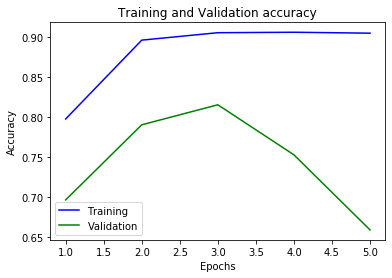

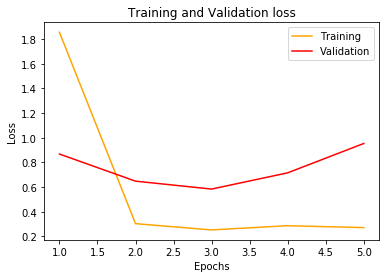

In [22]:

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)

# plotting accuracy 

plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss


plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



#### Creatng Improved model 
We are going to use VGG16 model here

In [23]:
vgg16_model=tf.keras.applications.vgg16.VGG16()
vgg16_model.summary() #lets look at summary.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
# Checking the type of model
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

#### Couple of things that need to be changes.
1. We need a sequential model unlike VGG16
2. The last Dense layer in VGG16 has 1000 ouputs but we need only two

In [25]:
# So we will create a blank sequential model and then add layers from VGG16 except last one
improved_model =tf.keras.models.Sequential()

for layer in vgg16_model.layers[:-1]:
    improved_model.add(layer)

improved_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [26]:
# By Default the VGG16 layers are well trained for image classification so no need to update the weights at each layer.
for layer in improved_model.layers:
    layer.trainable=False

In [27]:
# Adding dense layer with 2 outputs
improved_model.add(tf.keras.layers.Dense(2, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.001)
improved_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc']) 

#Lets look at the final model summary.
improved_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [28]:
history = improved_model.fit(train_generator,
                              epochs=10,
                              validation_data=validation_generator
                              ,callbacks=[checkpoint])

Epoch 1/10
173/173 [==============================] - 237s 1s/step - loss: 0.3833 - acc: 0.8338 - val_loss: 0.4179 - val_acc: 0.8031
Epoch 2/10
173/173 [==============================] - 248s 1s/step - loss: 0.2230 - acc: 0.9207 - val_loss: 0.4071 - val_acc: 0.8062
Epoch 3/10
173/173 [==============================] - 247s 1s/step - loss: 0.1872 - acc: 0.9299 - val_loss: 0.3309 - val_acc: 0.8531
Epoch 4/10
173/173 [==============================] - 239s 1s/step - loss: 0.1946 - acc: 0.9253 - val_loss: 0.4044 - val_acc: 0.8656
Epoch 5/10
173/173 [==============================] - 246s 1s/step - loss: 0.1467 - acc: 0.9496 - val_loss: 0.3107 - val_acc: 0.8969
Epoch 6/10
173/173 [==============================] - 250s 1s/step - loss: 0.1514 - acc: 0.9415 - val_loss: 0.2997 - val_acc: 0.8844
Epoch 7/10
173/173 [==============================] - 235s 1s/step - loss: 0.1399 - acc: 0.9514 - val_loss: 0.3653 - val_acc: 0.8844
Epoch 8/10
173/173 [==============================] - 238s 1s/step - 

#### Evaluating Improved Model

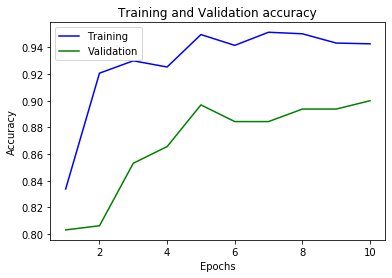

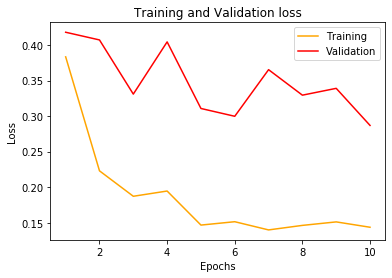

In [29]:

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)

# plotting accuracy 

plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss


plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [30]:
#from keras.models import load_model
import cv2

In [45]:
labels_dict={0:'Mask On',1:'Mask Off'}
color_dict={0:(0,255,0),1:(0,0,255)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

frame_width = int(webcam.get(3)) 
frame_height = int(webcam.get(4)) 
   
size1 = (frame_width, frame_height) 
   
# Below VideoWriter object will create 
# a frame of above defined The output  
# is stored in 'filename.avi' file. 
result1 = cv2.VideoWriter('capture.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, size1) 



# We load the xml file
classifier = cv2.CascadeClassifier('C:\ProgramData\Anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    
    
    
    im=cv2.flip(im,1,1) #Flip to act as a mirror
    
    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)
    
    # Draw rectangles around each face
    for f in faces:
        
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result=improved_model.predict(reshaped)
        
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    result1.write(im)   
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()
result1.release()

# Close all started windows
cv2.destroyAllWindows()